# Make a background model with Gammapy

## Introduction 
We will see how to build a background model from existing data.

We are working with only 4 runs here, just as an example. To build a coherent bkg model you normally have to use AGN runs.

It will use:
        
- [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html) to load the runs to use to build the bkg model
    
- [gammapy.data.ObservationGroupAxis](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationGroupAxis.html) and [gammapy.data.ObservationGroups](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationGroupAxis.html) to group the data to build the bkg model

- [gammapy.background.OffDataBackgroundMaker](http://docs.gammapy.org/en/latest/api/gammapy.background.OffDataBackgroundMaker.html) to make the acceptance curves in the different groups



## Import

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import astropy.units as u
from astropy.table import Table
import shutil
from astropy.coordinates import SkyCoord, Angle
from gammapy.data import DataStore, ObservationGroupAxis, ObservationGroups
from gammapy.background import OffDataBackgroundMaker
from gammapy.extern.pathlib import Path
from gammapy.catalog import SourceCatalogGammaCat
from gammapy.utils.energy import EnergyBounds
from gammapy.utils.axis import sqrt_space

## Build a background model from existing data

To compute the acceptance curve we only use 4 dummy Crab runs from gammapy_extra: 23523, 23526, 23559 and 23592

In [145]:
cwd=Path.cwd()
if Path.is_dir(cwd / Path("background")):
    shutil.rmtree(str(cwd / Path("background")))
data_store = DataStore.from_dir("$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2")


Prepare a scheme to group observations with similar observing conditions and create a new ObservationTable with the grouping ID for each run

In [146]:
# Create a background model from the 4 Crab runs for the counts ouside the exclusion region so here outside the Crab
# Create the directory for background storage
background_model_directory = cwd / Path("background")
background_model_directory.mkdir()

# Define the grouping you want to use to group the obervations to make the acceptance curves
# Here we use 2 Zenith angle bins only, you can also add efficiency bins for example etc...
axes = [ObservationGroupAxis('ZEN_PNT', [0, 49, 90], fmt='edges')]

# Create the ObservationGroups object
obs_groups = ObservationGroups(axes)
# write it to file
obs_groups.obs_groups_table.write(str(background_model_directory) + "/group-def.fits", overwrite=True)

# Create a new ObservationTable with the column group_id
# You give the runs list you want to use to produce the background model that are in your obs table. 
# Here very simple only the 4 Crab runs...
list_ids=[23523,23526,23559,23592]
obs_table_with_group_id = obs_groups.apply(data_store.obs_table.select_obs_id(list_ids))


We need a mask to remove known sources from the observation. We use TeVcat and exclude a circular region of at least 0.3° radius. Here since we use Crab runs, we will remove the Crab events from the FOV to select only the OFF events to build the acceptance curves. Of cource normally you use thousand of AGN runs to build coherent acceptance curves.

In [147]:
cat = SourceCatalogGammaCat()
exclusion_table = cat.table
exclusion_table.rename_column('ra', 'RA')
exclusion_table.rename_column('dec', 'DEC')
radius = exclusion_table['morph_sigma']
radius.value[np.isnan(radius)] = 0.3
exclusion_table['Radius'] = radius
exclusion_table=Table(exclusion_table)

Make the acceptance curves in the different group of observation conditions you defined above using the obs_table containaing the group id for each observation used to compute the bkg model

In [148]:
bgmaker = OffDataBackgroundMaker(data_store, str(background_model_directory), run_list=None,
                                 obs_table=obs_table_with_group_id
                                 , ntot_group=obs_groups.n_groups, excluded_sources=exclusion_table)
#bgmaker = OffDataBackgroundMaker(data_store, background_model_directory, run_list=None,
#                                 obs_table=obs_table_with_group_id
#                                 , ntot_group=obs_groups.n_groups, excluded_sources=Tevcatsources)
#ebounds and offset are default one in the method make_model
ebounds = EnergyBounds.equal_log_spacing(0.1, 100, 15, 'TeV')
offset = sqrt_space(start=0, stop=2.5, num=100) * u.deg
bgmaker.make_model("2D", ebounds=ebounds, offset=offset)

#Smooth the model
bgmaker.smooth_models("2D")

#Write the model
bgmaker.save_models("2D")
bgmaker.save_models(modeltype="2D", smooth=True)

### Plots
- Acceptance curve

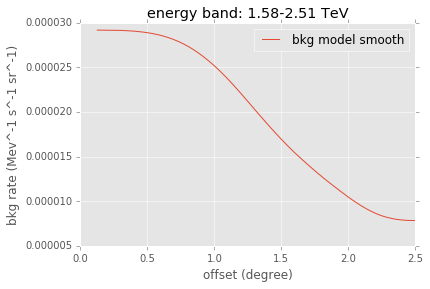

In [149]:
from gammapy.background import EnergyOffsetBackgroundModel
model=EnergyOffsetBackgroundModel.read(str(background_model_directory)+"/smooth_background_2D_group_000_table.fits.gz")
offset=model.bg_rate.offset_bin_center
energies=model.bg_rate.energy  
iE=6
plt.figure()
plt.plot(offset, model.bg_rate.data[iE,:], label="bkg model smooth")
plt.title("energy band: "+str("%.2f"%energies[iE].value)+"-"+str("%.2f"%energies[iE+1].value)+" TeV")
plt.xlabel("offset (degree)")
plt.ylabel("bkg rate (Mev^-1 s^-1 sr^-1)")
plt.legend()

- Spectrum

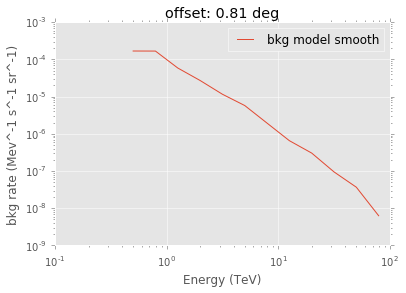

In [150]:
plt.figure()
plt.loglog(energies.log_centers, model.bg_rate.data[:,10], label="bkg model smooth")
plt.title("offset: "+str("%.2f"%offset[10].value)+" deg")
plt.xlabel("Energy (TeV)")
plt.ylabel("bkg rate (Mev^-1 s^-1 sr^-1)")
plt.legend()

- Image of the bkg Rate in energy and offset

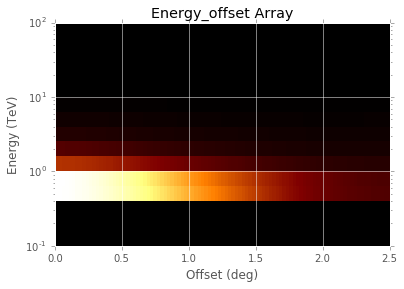

In [151]:
model.bg_rate.plot_image()

## New hdu table containing the background model

Here we first copy the dataset of the 4 crab runs from gammapy-extra to create the data you will use for the analysis. We use the same dataset to produce the bkg or for the analysis. Of course normally you produce the bkg model using thousands of AGN runs. 

Then we create a new hdu table containg for each observation a link to the bkg model to use depending of the observation conditions of the run

In [152]:

#Make a new hdu table in your dataset directory that contains the link to the acceptance curve to use to build the bkg model in your cube analysis
if Path.is_dir(cwd / Path("data")):
    shutil.rmtree(str(cwd / Path("data")))
data_directory = str(cwd / Path("data"))
ds= DataStore.from_dir("$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2")
ds.copy_obs(ds.obs_table, data_directory)
data_store = DataStore.from_dir(data_directory)

In [153]:
print data_store.hdu_table

OBS_ID HDU_TYPE HDU_CLASS  ...     MTIME                   MD5               
------ -------- ---------- ... ------------- --------------------------------
 23523      gti        gti ... 1455089616.34 9e402094c3a3e05ae4199b7cc9a01215
 23523   events     events ... 1455089616.34 9e402094c3a3e05ae4199b7cc9a01215
 23523     aeff    aeff_2d ... 1455089616.34 6430c082176f092e0aed0f2bf9840915
 23523    edisp   edisp_2d ... 1455089616.34 f580ea6cb104e4d6735b8d2940ac6774
 23523      psf psf_3gauss ... 1455089616.34 87f2d5c5ca56575a4a083b33e9700312
 23523      psf   psf_king ... 1455089616.34 7760e349a40883345406c7e3ea1cbd54
 23523      psf  psf_table ... 1455089616.35 74b745938341d0f64b79f60da7f1ad0f
 23526      psf   psf_king ... 1455089616.56 5873e4ec0771bdfcc6d82608199a4067
 23526      psf psf_3gauss ... 1455089616.56 f27364b40bbf8e35c747828e60224b28
 23526    edisp   edisp_2d ... 1455089616.56 c7e99f4d282a55c7fdd4024167bdbef5
   ...      ...        ... ...           ...                    

No associated background model in the hdu table. We create a new one with a model associated for each run.

In [154]:
#Create the new hdu table with a link to the background model
group_filename = str(background_model_directory) + '/group-def.fits'
hdu_index_table = bgmaker.make_total_index_table(
    data_store=data_store,
    modeltype='2D',
    out_dir_background_model=str(background_model_directory) ,
    filename_obs_group_table=group_filename, smooth=False
)

#Write the new hdu table
hdu_table_filename = data_directory  + '/hdu-index.fits.gz'
hdu_index_table.write(hdu_table_filename, overwrite=True)

In [155]:
print hdu_index_table

OBS_ID HDU_TYPE HDU_CLASS  ...     MTIME                   MD5               
------ -------- ---------- ... ------------- --------------------------------
 23523      gti        gti ... 1455089616.34 9e402094c3a3e05ae4199b7cc9a01215
 23523   events     events ... 1455089616.34 9e402094c3a3e05ae4199b7cc9a01215
 23523     aeff    aeff_2d ... 1455089616.34 6430c082176f092e0aed0f2bf9840915
 23523    edisp   edisp_2d ... 1455089616.34 f580ea6cb104e4d6735b8d2940ac6774
 23523      psf psf_3gauss ... 1455089616.34 87f2d5c5ca56575a4a083b33e9700312
 23523      psf   psf_king ... 1455089616.34 7760e349a40883345406c7e3ea1cbd54
 23523      psf  psf_table ... 1455089616.35 74b745938341d0f64b79f60da7f1ad0f
 23526      psf   psf_king ... 1455089616.56 5873e4ec0771bdfcc6d82608199a4067
 23526      psf psf_3gauss ... 1455089616.56 f27364b40bbf8e35c747828e60224b28
 23526    edisp   edisp_2d ... 1455089616.56 c7e99f4d282a55c7fdd4024167bdbef5
   ...      ...        ... ...           ...                    

In [156]:
print hdu_index_table[-4]["FILE_DIR"], " ", hdu_index_table[-4]["FILE_NAME"]

/Users/jouvin/Desktop/these/test_Gammapy/gammapy-extra/notebooks/background   background_2D_group_000_table.fits.gz


In [157]:
print hdu_index_table[-1]["FILE_DIR"], " ", hdu_index_table[-1]["FILE_NAME"]

/Users/jouvin/Desktop/these/test_Gammapy/gammapy-extra/notebooks/background   background_2D_group_001_table.fits.gz


## Exercises

- Use real AGN run
- Change the binning for the grouping: thinner zenithal bin, add efficiency binning ....
- Change the energy binning (ebounds) and the offset (offset) used to compute the acceptance curve


Now we've created a background model in the http://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/background/index.html#bkg-2d-format format.
In future tutorials, we will use it as a background model component for source analysis.